# XFeat matching example (sparse and semi-dense)

## First, clone repository

In [1]:
#!cd /content && git clone 'https://github.com/verlab/accelerated_features.git'
#%cd /content/accelerated_features

Cloning into 'accelerated_features'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 27 (delta 0), reused 5 (delta 0), pack-reused 16
Receiving objects: 100% (27/27), 13.29 MiB | 26.96 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/accelerated_features


## Initialize XFeat

In [1]:
import numpy as np
import os
import torch
import tqdm
import cv2
import matplotlib.pyplot as plt

from modules.xfeat import XFeat

xfeat = XFeat()

#Load some example images
im1 = cv2.imread('coco_20k/frame03342_rrgb_jpg.rf.f61dc581524329c19a2d11cc38384ceb.jpg')
im2 = cv2.imread('coco_20k/frame03342_rrgb_jpg.rf.f61dc581524329c19a2d11cc38384ceb.jpg')

loading weights from: G:\PyProjects\accelerated_features\modules/../weights/xfeat.pt


G:\PyProjects\accelerated_features\modules\xfeat.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(weights, map_location=self.dev))


## Simple function that fits an homography in a set of matches and draw the homography transform

In [2]:
import cv2
import numpy as np

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches


## Matching example - sparse setting

In [3]:
#Use out-of-the-box function for extraction + MNN matching
mkpts_0, mkpts_1 = xfeat.match_xfeat(im1, im2, top_k = 4096)

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'

## Matching example - Semi-dense setting

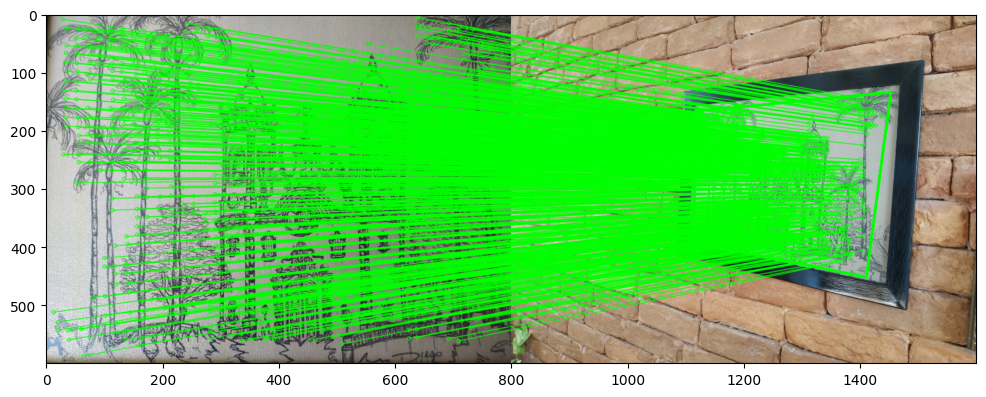

(<matplotlib.image.AxesImage at 0x7a71c6642440>, None)

In [5]:
#Use out-of-the-box function for extraction + coarse-to-fine matching
mkpts_0, mkpts_1 = xfeat.match_xfeat_star(im1, im2, top_k = 8000)

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()